<a href="https://colab.research.google.com/github/alejogomez17/IA-tapabocas/blob/main/Proyecto_tapabocas_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2
import scipy
import os
%matplotlib inline
import matplotlib.pyplot as plt
from time import time
from io import StringIO

from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

from keras.utils import np_utils
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.vis_utils import plot_model #Pintar el modelo

In [ ]:
## ruta base de las del dataset de las imágenes
BASE_DIR = '/content/drive/MyDrive/inteligencia artificial/Inteligencia Artificial - EspecializaciónSW/trabajos/proyecto/dataset-mask2/'

In [ ]:
# cargar las imagenes en X,y con los tres canales de las imágenes
def get_data_multi_channel(folder):
    """
    Cargar los datos y las etiquetas desde una carpeta dada.
    """
    X = []
    y = []

    for mask_type in os.listdir(folder):
        if not mask_type.startswith('.'):
            if mask_type in ['correcto']:
                ## tapabocas bien puesto
                label = '0'
            else:
                ## tapabocas mal puesto
                label = '1'
            for image_filename in os.listdir(folder + mask_type):
                img_file = cv2.imread(folder + mask_type + '/' + image_filename)
                if img_file is not None:
                    image = cv2.cvtColor(img_file, cv2.COLOR_BGR2RGB)
                    #redimensionar para que todas queden con el mismo tamaño
                    image = cv2.resize(image, (224, 224))
                    img_arr = np.asarray(image)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [ ]:
X_train_multi_channel, y_train_multi_channel = get_data_multi_channel(BASE_DIR + 'train/')
X_test_multi_channel, y_test_multi_channel = get_data_multi_channel(BASE_DIR + 'test/')

Verificamos el tamaño de las imágenes cargadas

In [ ]:
X_train_multi_channel.shape, y_train_multi_channel.shape, X_test_multi_channel.shape, y_test_multi_channel.shape

((1251, 224, 224, 3), (1251,), (339, 224, 224, 3), (339,))

Vamos a trabajar con un set de imágenes de 1590 imágenes, divididas en:
- 1251 para entrenar
- 339 para test.

In [ ]:
## tendremos un método para graficar el histórico y ver que tan buenos son los resultado obtenidos por un modelo
def plot_learning_curve(history):
    plt.figure (figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

# **Super Vector Machine**

**Trabajaremos con otras variables para no tocar lo datos iniciales por si se quiere dar otro uso.**

In [ ]:
X_train = X_train_multi_channel
y_train = y_train_multi_channel
X_test = X_test_multi_channel
y_test = y_test_multi_channel


In [ ]:
#verificamos integridad
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1251, 224, 224, 3), (1251,), (339, 224, 224, 3), (339,))

In [ ]:
## transformar X_train y X_test a un vector lineal
nsamples, nx, ny, ncha = X_train.shape
nsamples2, nx2, ny2, ncha2 = X_test.shape
X_train_new = X_train.reshape((nsamples,nx*ny*ncha))
X_test = X_test.reshape((nsamples2,nx2*ny2*ncha2))

## label encoder para linealizar las tiquetas
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
## Verificamos la transformación
X_train_new.shape, X_test.shape

((1251, 150528), (339, 150528))

In [ ]:
## Validamos que no se ha perdido la cantidad de etiquetas
y_train.shape, y_test.shape

((1251,), (339,))

In [ ]:
## Vemos como quedaron las etiquetas codificadas
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
## super vector machine con el kernel 'linear'
clf_l = svm.SVC(kernel='linear', C = 100.0)
clf_l.fit(X_train_new,y_train)
y_pred_l = clf_l.predict(X_test)

print(classification_report(y_test, y_pred_l))
print(confusion_matrix(y_test, y_pred_l))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       156
           1       0.88      0.89      0.89       183

    accuracy                           0.88       339
   macro avg       0.88      0.87      0.88       339
weighted avg       0.88      0.88      0.88       339

[[134  22]
 [ 20 163]]


**Resultados:**

Vemos como la precisión se encuentra en 87% para identificar tapa bocas bien puestos y 88% para tapabocas mal puesto.

In [ ]:
clf_r = svm.SVC(kernel='rbf', gamma=0.1, C = 100.0)
clf_r.fit(X_train_new,y_train)
y_pred_r = clf_r.predict(X_test)

print(classification_report(y_test, y_pred_r))
print(confusion_matrix(y_test, y_pred_r))



              precision    recall  f1-score   support

           0       1.00      0.08      0.14       156
           1       0.56      1.00      0.72       183

    accuracy                           0.58       339
   macro avg       0.78      0.54      0.43       339
weighted avg       0.76      0.58      0.45       339

[[ 12 144]
 [  0 183]]


**Resultados:**

Vemos como la precisión se encuentra en 100% para identificar tapa bocas bien puestos y 56% para tapabocas mal puesto. Se puede observar un gran overfitting y una solución poco viable al problema.

In [ ]:
score_l = accuracy_score(y_test, y_pred_l)
score_r = accuracy_score(y_test, y_pred_r)
score_l, score_r 

(0.8761061946902655, 0.5752212389380531)

In [ ]:
confusion_matrix(y_test, y_pred_l), confusion_matrix(y_test, y_pred_r)

(array([[134,  22],
        [ 20, 163]]), array([[ 12, 144],
        [  0, 183]]))

No handles with labels found to put in legend.


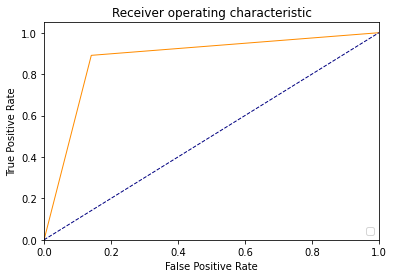

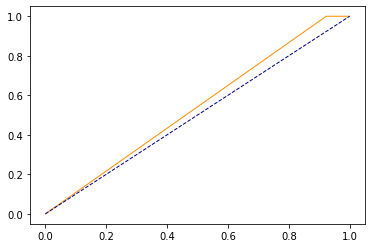

In [ ]:
plt.figure()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

## para svc linear
fpr, tpr, thresholds = roc_curve(y_test, y_pred_l)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.show()

## para svc rbf
fpr, tpr, thresholds = roc_curve(y_test, y_pred_r)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.show()

Se puede ver lo alejado que estamos del 100%, este problema no debe ser realizado con svm

In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(y_test, y_pred_l)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[134  22]
 [ 20 163]]
acc: 0.8761
sensitivity: 0.8590
specificity: 0.8907


In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(y_test, y_pred_r)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[ 12 144]
 [  0 183]]
acc: 0.5752
sensitivity: 0.0769
specificity: 1.0000


# **Red Neuronal**

In [ ]:
## Cargar las imágenes en X,y con un solo canal
def get_data_one_channel(folder):
    """
    Cargar los datos y las etiquetas desde una carpeta dada.
    """
    X = []
    y = []

    for mask_type in os.listdir(folder):
        if not mask_type.startswith('.'):
            if mask_type in ['correcto']:
                ## tapabocas bien puesto
                label = '0'
            else:
                ## tapabocas mal puesto
                label = '1'
            for image_filename in os.listdir(folder + mask_type):
                img_file = cv2.imread(folder + mask_type + '/' + image_filename)
                if img_file is not None:
                    image = cv2.cvtColor(img_file, cv2.COLOR_BGR2GRAY) ## esto se aplicado para lograr obtenerlas en un canal
                    image = cv2.resize(image, (224, 224))
                    img_arr = np.asarray(image)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [ ]:
X_train_one_channel, y_train_one_channel = get_data_one_channel(BASE_DIR + 'train/')
X_test_one_channel, y_test_one_channel = get_data_one_channel(BASE_DIR + 'test/')

In [ ]:
X_train_rn = X_train_one_channel
X_test_rn = X_test_one_channel 
y_train_rn = y_train_one_channel
y_test_rn = y_test_one_channel

In [ ]:
X_train_rn.shape, y_train_rn.shape, X_test_rn.shape, y_test_rn.shape

((1251, 224, 224), (1251,), (339, 224, 224), (339,))

(<matplotlib.image.AxesImage at 0x7fa3d0529b50>, '0')

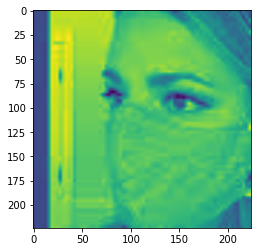

In [ ]:
plt.imshow(X_train_rn[150,:,:]),y_train_rn[150]

In [ ]:
seed = 7
np.random.seed(seed)

num_pixels = X_train_rn.shape[1] * X_train_rn.shape[2]
X_train_rn = X_train_rn.reshape(X_train_rn.shape[0], num_pixels) .astype('float32')
X_test_rn = X_test_rn.reshape(X_test_rn.shape[0], num_pixels).astype('float32')

# normalizamos las imágenes desde 0-255 to 0-1
X_train_rn = X_train_rn / 255
X_test_rn = X_test_rn / 255

# normalizamos los labels
y_train_rn = np_utils.to_categorical(y_train_rn)
y_test_rn = np_utils.to_categorical(y_test_rn)
num_classes = y_test_rn.shape[1]

In [ ]:
num_pixels, num_classes

(50176, 2)

In [ ]:
## modelo básico con función de activación softmax y compilando con categorical_crossentpy
def baseline_model():
    model = Sequential()
    ## una capa densa con el número de pixeles como entrada
    model.add(Dense(32, input_dim=num_pixels, activation='relu'))
    ## capas densas intermedias
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

In [ ]:
## instancia y descripción del modelo
model = baseline_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                1605664   
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 66        
Total params: 1,620,290
Trainable params: 1,620,290
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_test_rn.shape, y_test_rn.shape

((339, 50176), (339, 2))

In [ ]:
model.fit(X_train_rn, y_train_rn, validation_data=(X_test_rn, y_test_rn), epochs=20, batch_size=64, verbose=2)

scores = model.evaluate(X_test_rn, y_test_rn, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/20
20/20 - 1s - loss: 0.6969 - accuracy: 0.5092 - val_loss: 0.7450 - val_accuracy: 0.4543
Epoch 2/20
20/20 - 0s - loss: 0.6967 - accuracy: 0.5204 - val_loss: 0.6675 - val_accuracy: 0.6667
Epoch 3/20
20/20 - 0s - loss: 0.6514 - accuracy: 0.6411 - val_loss: 0.7126 - val_accuracy: 0.4808
Epoch 4/20
20/20 - 0s - loss: 0.6913 - accuracy: 0.5500 - val_loss: 0.7745 - val_accuracy: 0.5487
Epoch 5/20
20/20 - 0s - loss: 0.6461 - accuracy: 0.6379 - val_loss: 0.6657 - val_accuracy: 0.5900
Epoch 6/20
20/20 - 0s - loss: 0.6187 - accuracy: 0.6451 - val_loss: 0.5939 - val_accuracy: 0.6873
Epoch 7/20
20/20 - 0s - loss: 0.6106 - accuracy: 0.6715 - val_loss: 0.6604 - val_accuracy: 0.5664
Epoch 8/20
20/20 - 0s - loss: 0.5927 - accuracy: 0.6843 - val_loss: 0.5743 - val_accuracy: 0.7021
Epoch 9/20
20/20 - 0s - loss: 0.5517 - accuracy: 0.7130 - val_loss: 0.6291 - val_accuracy: 0.6283
Epoch 10/20
20/20 - 0s - loss: 0.5813 - accuracy: 0.7114 - val_loss: 0.6774 - val_accuracy: 0.6224
Epoch 11/20
20/20 -

In [ ]:
# crear un modelo secuencial creando capas densas 
def create_dense(layer_sizes):
    model = Sequential()
    model.add(Dense(layer_sizes[0] , input_dim=num_pixels, activation='relu'))
    for s in layer_sizes[1:]:
        model.add(Dense(units = s, activation = 'relu'))

    model.add(Dense(units=num_classes, activation='softmax'))
    return model

In [ ]:
## evaluar un modelo indicado, mostrando el resúmen, compilando con categorical_crossentropy, entrenando y mostrando el resultado.
def evaluate(model, batch_size=128, epochs=5):
    model.summary()
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_rn, y_train_rn, validation_data=(X_test_rn, y_test_rn), epochs=epochs, batch_size=batch_size, verbose=2)
    scores = model.evaluate(X_test_rn, y_test_rn, verbose=0)
    print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# ir añadiendo capas densas cada una de 64 neuronas
for layers in range(1, 5):
    model = create_dense([64] * layers)
    evaluate(model)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                3211328   
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 130       
Total params: 3,211,458
Trainable params: 3,211,458
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
10/10 - 1s - loss: 1.7684 - accuracy: 0.5324 - val_loss: 0.7126 - val_accuracy: 0.4631
Epoch 2/5
10/10 - 0s - loss: 0.6814 - accuracy: 0.5556 - val_loss: 0.7074 - val_accuracy: 0.4631
Epoch 3/5
10/10 - 0s - loss: 0.6687 - accuracy: 0.5715 - val_loss: 0.6579 - val_accuracy: 0.5929
Epoch 4/5
10/10 - 0s - loss: 0.6518 - accuracy: 0.5987 - val_loss: 0.7858 - val_accuracy: 0.4543
Epoch 5/5
10/10 - 0s - loss: 0.6163 - accuracy: 0.6811 - val_loss: 0.5930 - val_accuracy: 0.7168
Baseline Error: 28.32

**Resultados:**

No se ha obtenido un buen resultado, el mejor ha sido utilizar solo una capa densa de 64, pero solo obteniendo un valor para accuracy de 71.68%.

In [ ]:
## Vamos a intentar ir agregando i capas densas de diferentes tamaños.
for i in range(1,5):
  for nodes in [32, 64, 128, 256, 512, 1024, 2048]:
      model = create_dense([nodes]* i)
      evaluate(model)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_129 (Dense)            (None, 32)                1605664   
_________________________________________________________________
dense_130 (Dense)            (None, 2)                 66        
Total params: 1,605,730
Trainable params: 1,605,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
10/10 - 1s - loss: 1.0909 - accuracy: 0.5196 - val_loss: 0.6922 - val_accuracy: 0.5487
Epoch 2/5
10/10 - 0s - loss: 0.6927 - accuracy: 0.5276 - val_loss: 0.6913 - val_accuracy: 0.5428
Epoch 3/5
10/10 - 0s - loss: 0.6911 - accuracy: 0.5284 - val_loss: 0.6888 - val_accuracy: 0.5398
Epoch 4/5
10/10 - 0s - loss: 0.6893 - accuracy: 0.5268 - val_loss: 0.6882 - val_accuracy: 0.5398
Epoch 5/5
10/10 - 0s - loss: 0.6873 - accuracy: 0.5460 - val_loss: 0.6964 - val_accuracy: 0.4661
Baseline Error: 53.3

**Probamos con módelos diferentes agregando capas n capas densas por diferente número de nodos, obteniendo los mejores resultados con los siguientes parámetros:**

- 1 capa 256 nodos	acc: 68.73%, err: 31.27%
- 1 capa 512 nodos	acc: 73.45%, err: 26.55%
- 3 capas 32 nodos	acc: 70.50%, err: 29.50%
- 3 capas 64 nodos	acc: 69.03%, err: 30.97%
- 4 capas 1024 nodos	acc: 70.50%, err: 29.50%

**Al parecer crear capas densas no ayuda a tener un mejor resultado, pero también somos conscientes que esto es debido a que nuestro problema se basa en reconocer formas de la imagen y es por esto que este tipo de red no nos sirve de a mucho.**

# **Red Neuronal Convolucional**

In [ ]:
## Reutilizamos la data ya cargada en x,y en 3 capas.
X_train_cn = X_train_multi_channel
y_train_cn = y_train_multi_channel
X_test_cn = X_test_multi_channel
y_test_cn = y_test_multi_channel

In [ ]:
X_train_cn.shape, X_test_cn.shape, y_train_cn.shape ,y_test_cn.shape

((1251, 224, 224, 3), (339, 224, 224, 3), (1251,), (339,))

In [ ]:
seed = 7
np.random.seed(seed)

# normalizamos los valores de las imágenes de 0-255 a 0-1
X_train_cn = X_train_cn / 255
X_test_cn = X_test_cn / 255

# normalizamos los labels en categorías
y_train_cn = np_utils.to_categorical(y_train_cn)
y_test_cn = np_utils.to_categorical(y_test_cn)
num_classes = y_test_cn.shape[1]

In [ ]:
X_train

In [ ]:
## empezaremos probando con un model stándar donde se usan 64 filtros de 5x5 y una capa densa de 128
def baseline_model_cnn():

    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=(224, 224,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2)) ## apagamos el 20% de los nodos
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
## Construimos el model
model = baseline_model_cnn()
# Entrenamos con 50 épocas y 32 batchsize
model.fit(X_train_cn, y_train_cn, validation_data=(X_test_cn, y_test_cn), epochs=50, batch_size=32)
# Evaluamos
scores = model.evaluate(X_test_cn, y_test_cn, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/50
40/40 [==============================] - 34s 114ms/step - loss: 16.3382 - accuracy: 0.6350 - val_loss: 0.4078 - val_accuracy: 0.8466
Epoch 2/50
40/40 [==============================] - 3s 82ms/step - loss: 0.2900 - accuracy: 0.8946 - val_loss: 0.5623 - val_accuracy: 0.8112
Epoch 3/50
40/40 [==============================] - 3s 81ms/step - loss: 0.2698 - accuracy: 0.8910 - val_loss: 0.4501 - val_accuracy: 0.7847
Epoch 4/50
40/40 [==============================] - 3s 82ms/step - loss: 0.1639 - accuracy: 0.9413 - val_loss: 0.3137 - val_accuracy: 0.8732
Epoch 5/50
40/40 [==============================] - 3s 82ms/step - loss: 0.1576 - accuracy: 0.9423 - val_loss: 0.3013 - val_accuracy: 0.8879
Epoch 6/50
40/40 [==============================] - 3s 82ms/step - loss: 0.1089 - accuracy: 0.9599 - val_loss: 0.2685 - val_accuracy: 0.8909
Epoch 7/50
40/40 [==============================] - 3s 82ms/step - loss: 0.1537 - accuracy: 0.9464 - val_loss: 0.3490 - val_accuracy: 0.8702
Epoch 8/50

Vemos una mejora real al usar una red convolucional, y sobre todo con un filtro, obteniendo acc: 89.97% y err: 10.03%.

In [ ]:
## empezaremos probando con un model stándar donde se usan 64 filtros de 5x5 y una capa densa de 128
def baseline_model_cnn_multi_filtros_1():

    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=(224, 224,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
## Construimos el model
model = baseline_model_cnn_multi_filtros_1()
# Entrenamos con 50 épocas y 32 batchsize
model.fit(X_train_cn, y_train_cn, validation_data=(X_test_cn, y_test_cn), epochs=50, batch_size=32)
# Evaluamos
scores = model.evaluate(X_test_cn, y_test_cn, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/50
40/40 [==============================] - 6s 107ms/step - loss: 0.7645 - accuracy: 0.6329 - val_loss: 0.3427 - val_accuracy: 0.8555
Epoch 2/50
40/40 [==============================] - 3s 83ms/step - loss: 0.3169 - accuracy: 0.8750 - val_loss: 0.3702 - val_accuracy: 0.8407
Epoch 3/50
40/40 [==============================] - 3s 83ms/step - loss: 0.2652 - accuracy: 0.8922 - val_loss: 0.2673 - val_accuracy: 0.8968
Epoch 4/50
40/40 [==============================] - 3s 84ms/step - loss: 0.2127 - accuracy: 0.9316 - val_loss: 0.3152 - val_accuracy: 0.8820
Epoch 5/50
40/40 [==============================] - 3s 83ms/step - loss: 0.1317 - accuracy: 0.9563 - val_loss: 0.3596 - val_accuracy: 0.8289
Epoch 6/50
40/40 [==============================] - 3s 83ms/step - loss: 0.1641 - accuracy: 0.9404 - val_loss: 0.8862 - val_accuracy: 0.7109
Epoch 7/50
40/40 [==============================] - 3s 82ms/step - loss: 0.2163 - accuracy: 0.9110 - val_loss: 0.2550 - val_accuracy: 0.8702
Epoch 8/50
4

El agregar varios filtros no ha servido mucho, intentamos el mismo modelo pero apagando más nodos.

In [ ]:
## empezaremos probando con un model stándar donde se usan 64 filtros de 5x5 y una capa densa de 128
def baseline_model_cnn_multi_filtros_2():

    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=(224, 224,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.7)) ## se apagarán 70% de los nodos
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
## Construimos el model
model = baseline_model_cnn_multi_filtros_2()
# Entrenamos con 50 épocas y 32 batchsize
history = model.fit(X_train_cn, y_train_cn, validation_data=(X_test_cn, y_test_cn), epochs=50, batch_size=32)
# Evaluamos
scores = model.evaluate(X_test_cn, y_test_cn, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/50
40/40 [==============================] - 38s 109ms/step - loss: 0.7505 - accuracy: 0.6299 - val_loss: 0.3974 - val_accuracy: 0.8437
Epoch 2/50
40/40 [==============================] - 3s 81ms/step - loss: 0.3791 - accuracy: 0.8704 - val_loss: 0.4121 - val_accuracy: 0.8260
Epoch 3/50
40/40 [==============================] - 3s 82ms/step - loss: 0.3205 - accuracy: 0.8797 - val_loss: 0.3618 - val_accuracy: 0.8260
Epoch 4/50
40/40 [==============================] - 3s 81ms/step - loss: 0.2906 - accuracy: 0.8911 - val_loss: 0.3177 - val_accuracy: 0.8761
Epoch 5/50
40/40 [==============================] - 3s 81ms/step - loss: 0.2849 - accuracy: 0.9023 - val_loss: 0.3481 - val_accuracy: 0.8643
Epoch 6/50
40/40 [==============================] - 3s 82ms/step - loss: 0.2754 - accuracy: 0.9047 - val_loss: 0.2940 - val_accuracy: 0.8850
Epoch 7/50
40/40 [==============================] - 3s 81ms/step - loss: 0.2928 - accuracy: 0.8824 - val_loss: 0.3552 - val_accuracy: 0.8437
Epoch 8/50


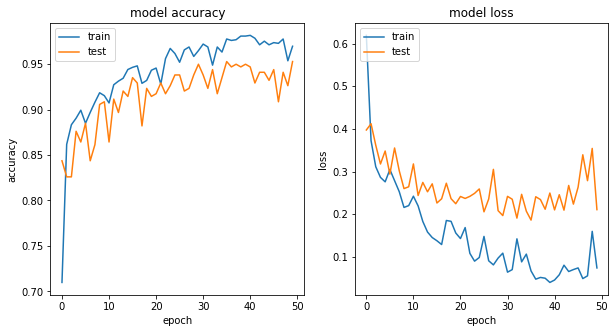

In [ ]:
plot_learning_curve(history)

Se nota una mejora en el valor de accuracy logrando un 95.28%, ha sido notoria la mejora al desconectar un porcentaje mayor de nodos, ahora queremos intentar crear un model que nos permita tunnear el tamaño de los filtros que vamos a usar

In [ ]:
def baseline_model_cnn_multi_filtros_3(t_filtro:5):

    model = Sequential()
    model.add(Conv2D(64, (t_filtro, t_filtro), input_shape=(224, 224,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (t_filtro, t_filtro), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (t_filtro, t_filtro), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.7)) ## se apagarán 70% de los nodos
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
results = "Resultados\n"
for indice in range(1, 6):
  ## Construimos el model
  model = baseline_model_cnn_multi_filtros_3(indice)
  # Entrenamos con 50 épocas y 32 batchsize
  model.fit(X_train_cn, y_train_cn, validation_data=(X_test_cn, y_test_cn), epochs=50, batch_size=32)
  # Evaluamos
  scores = model.evaluate(X_test_cn, y_test_cn, verbose=0)
  r = ("Error: %.2f%%, Acc: %.2f%% usando filtros de %r " % ((100-scores[1]*100), scores[1]*100, str(indice)+" X "+str(indice)))+"\n"
  print(r)
  results += r+"\n"
print(results)

Epoch 1/50
40/40 [==============================] - 4s 79ms/step - loss: 0.9702 - accuracy: 0.6242 - val_loss: 0.4632 - val_accuracy: 0.7847
Epoch 2/50
40/40 [==============================] - 3s 71ms/step - loss: 0.3867 - accuracy: 0.8428 - val_loss: 0.3513 - val_accuracy: 0.8584
Epoch 3/50
40/40 [==============================] - 3s 72ms/step - loss: 0.3407 - accuracy: 0.8749 - val_loss: 0.3310 - val_accuracy: 0.8702
Epoch 4/50
40/40 [==============================] - 3s 72ms/step - loss: 0.2865 - accuracy: 0.8851 - val_loss: 0.3099 - val_accuracy: 0.8732
Epoch 5/50
40/40 [==============================] - 3s 72ms/step - loss: 0.2719 - accuracy: 0.8966 - val_loss: 0.2812 - val_accuracy: 0.8938
Epoch 6/50
40/40 [==============================] - 3s 73ms/step - loss: 0.2670 - accuracy: 0.9002 - val_loss: 0.2681 - val_accuracy: 0.8791
Epoch 7/50
40/40 [==============================] - 3s 72ms/step - loss: 0.2094 - accuracy: 0.9079 - val_loss: 0.2356 - val_accuracy: 0.9056
Epoch 8/50
40

Vemos que agregar 3 capas de filtros de 1x1, mejora el accuracy llegando a un 95.28%, siendo el mejor valor obtenido para nuestro problema. 

Intentemos ver que pasa si se varían las épocas y los batch size.

In [ ]:
model_keras = KerasClassifier(build_fn=baseline_model_cnn_multi_filtros_3, t_filtro=1, verbose=1)
batch_size = [16, 32, 64]
epochs = [10,30, 50,100]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model_keras, param_grid=param_grid)
grid_result = grid.fit(X_train_cn, y_train_cn)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 41/50
63/63 [==============================] - 2s 32ms/step - loss: 0.0383 - accuracy: 0.9888
Epoch 42/50
63/63 [==============================] - 2s 32ms/step - loss: 0.0437 - accuracy: 0.9816
Epoch 43/50
63/63 [==============================] - 2s 32ms/step - loss: 0.0671 - accuracy: 0.9794
Epoch 44/50
63/63 [==============================] - 2s 33ms/step - loss: 0.0227 - accuracy: 0.9934
Epoch 45/50
63/63 [==============================] - 2s 32ms/step - loss: 0.0155 - accuracy: 0.9953
Epoch 46/50
63/63 [==============================] - 2s 32ms/step - loss: 0.0193 - accuracy: 0.9932
Epoch 47/50
63/63 [==============================] - 2s 33ms/step - loss: 0.0111 - accuracy: 0.9988
Epoch 48/50
63/63 [==============================] - 2s 32ms/step - loss: 0.0385 - accuracy: 0.9898
Epoch 49/50
63/63 [==============================] - 2s 32ms/step - loss: 0.0832 - accuracy: 0.9640
Epoch 50/50
16/16 [====================

Probamos con los resultados antes obtenidos y usando filtros de 1x1, batch_size de 64 y 10 épocas.

In [ ]:
## Construimos el model
model = baseline_model_cnn_multi_filtros_3(1)
# Entrenamos con 50 épocas y 32 batchsize
history = model.fit(X_train_cn, y_train_cn, validation_data=(X_test_cn, y_test_cn), epochs=10, batch_size=64)
# Evaluamos
scores = model.evaluate(X_test_cn, y_test_cn, verbose=0)
r = ("Error: %.2f%%, Acc: %.2f%% usando filtros de %r " % ((100-scores[1]*100), scores[1]*100, str(1)+" X "+str(1)))+"\n"
print(r)

Epoch 1/10
20/20 [==============================] - 55s 3s/step - loss: 1.2849 - accuracy: 0.4905 - val_loss: 0.5663 - val_accuracy: 0.7375
Epoch 2/10
20/20 [==============================] - 52s 3s/step - loss: 0.4909 - accuracy: 0.7911 - val_loss: 0.3979 - val_accuracy: 0.8319
Epoch 3/10
20/20 [==============================] - 52s 3s/step - loss: 0.3465 - accuracy: 0.8842 - val_loss: 0.3253 - val_accuracy: 0.8614
Epoch 4/10
20/20 [==============================] - 52s 3s/step - loss: 0.3075 - accuracy: 0.8794 - val_loss: 0.3435 - val_accuracy: 0.8496
Epoch 5/10
20/20 [==============================] - 52s 3s/step - loss: 0.3036 - accuracy: 0.8833 - val_loss: 0.2870 - val_accuracy: 0.8702
Epoch 6/10
20/20 [==============================] - 52s 3s/step - loss: 0.2601 - accuracy: 0.9049 - val_loss: 0.2833 - val_accuracy: 0.8732
Epoch 7/10
20/20 [==============================] - 52s 3s/step - loss: 0.2241 - accuracy: 0.9123 - val_loss: 0.2630 - val_accuracy: 0.8997
Epoch 8/10
20/20 [==

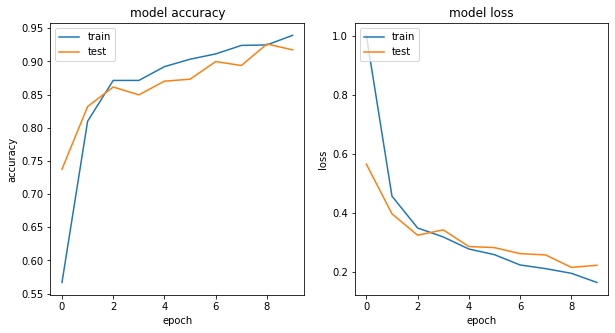

In [ ]:
plot_learning_curve(history)

Con el keras clasifier no se obtiene un resultado muy bueno, se esperaba mejor resultado.

**Observación:**
Los mejores resultados se han obtenido con las redes convolucionales, pero idenificamos que los modelos que hemos utilizado, les agregamos una función de activación llamada 'softmax' y compilamos con 'categorical_crossentropy', dado que nuestro problema es de solución binaria, tapabocas bien y mal puesto (0,1) hemos encontrado que podemos usar un modelo más óptimo a nuestras necesidades, utilizando una función de activación 'sigmoid' y compilando con 'binary_crossentropy'

In [ ]:
def model_cnn_binary():

    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=(224, 224,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.7)) ## desconectamos el 70% de los nodos
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

Con el modelo anterior podremos usar las funciones descritas anteriormente, adicional mantenemos el dropout del 0.7 ya que mostró mejores resultados anteriormente.

**Posible inconventiente**
Este modelo, a diferencia del anterior, solo tendrá un nodo de salida, así que nuestros labels deberán ser codificados solo a (0,1) y no a (1,0 0,1).

In [ ]:
## nuevas variables para hacer la nueva codificación
y_test_binario = y_test_multi_channel
y_train_binario =y_train_multi_channel
encoder = LabelEncoder()
encoder.fit(y_train_binario)

encoder = LabelEncoder()
encoder.fit(y_train_binario)
y_train_binario = encoder.transform(y_train_binario)
y_test_binario = encoder.transform(y_test_binario)

In [ ]:
y_test_binario, y_test_cn

In [ ]:
## Construimos el modelo descrito anteriormente, usaremos los mismos datos para X pero para y los obtenidos en el código anterior
model_binary = model_cnn_binary()
# Entrenar
model_binary.fit(X_train_cn, y_train_binario, validation_data=(X_test_cn, y_test_binario), epochs=50, batch_size=32)
# Evaluación
scores = model_binary.evaluate(X_test_cn, y_test_binario, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/50
40/40 [==============================] - 5s 109ms/step - loss: 16.1198 - accuracy: 0.6318 - val_loss: 0.5333 - val_accuracy: 0.8112
Epoch 2/50
40/40 [==============================] - 4s 101ms/step - loss: 0.4516 - accuracy: 0.8408 - val_loss: 0.4035 - val_accuracy: 0.8673
Epoch 3/50
40/40 [==============================] - 4s 101ms/step - loss: 0.7940 - accuracy: 0.8200 - val_loss: 1.0100 - val_accuracy: 0.7375
Epoch 4/50
40/40 [==============================] - 4s 101ms/step - loss: 0.4837 - accuracy: 0.8559 - val_loss: 0.2926 - val_accuracy: 0.8968
Epoch 5/50
40/40 [==============================] - 4s 101ms/step - loss: 0.5490 - accuracy: 0.8764 - val_loss: 0.3042 - val_accuracy: 0.9027
Epoch 6/50
40/40 [==============================] - 4s 102ms/step - loss: 0.2805 - accuracy: 0.8984 - val_loss: 0.3168 - val_accuracy: 0.8938
Epoch 7/50
40/40 [==============================] - 4s 101ms/step - loss: 0.2984 - accuracy: 0.8961 - val_loss: 3.0187 - val_accuracy: 0.7257
Epoch

En nuestro primer intento tenemos un accuracy de 92.04% y un error: 7.96%, ahora vamos a intentar tunnear un poco el modelo, agregando varias capas de filtros.

In [ ]:
def model_cnn_binary_tunn(t_filtro: 5):
    # create model
    model = Sequential()
    model.add(Conv2D(64, (t_filtro, t_filtro), input_shape=(224, 224,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (t_filtro, t_filtro), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (t_filtro, t_filtro), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [ ]:
resultados = "resultado: \n"
for indice in range(1,6):
  model = model_cnn_binary_tunn(indice)

  model.fit(X_train_cn, y_train_binario, validation_data=(X_test_cn, y_test_binario), epochs=50, batch_size=32)
  
  scores = model.evaluate(X_test_cn, y_test_binario, verbose=0)
  r = ("Error: %.2f%%, Acc: %.2f%% usando filtros de %r " % ((100-scores[1]*100), scores[1]*100, str(indice)+" X "+str(indice)))+"\n"
  print(r)
  resultados += r
print(resultados)

Epoch 1/50
40/40 [==============================] - 4s 79ms/step - loss: 2.3329 - accuracy: 0.6100 - val_loss: 0.5287 - val_accuracy: 0.7935
Epoch 2/50
40/40 [==============================] - 3s 73ms/step - loss: 0.4235 - accuracy: 0.8235 - val_loss: 0.4651 - val_accuracy: 0.8289
Epoch 3/50
40/40 [==============================] - 3s 72ms/step - loss: 0.3335 - accuracy: 0.8748 - val_loss: 0.3753 - val_accuracy: 0.8407
Epoch 4/50
40/40 [==============================] - 3s 71ms/step - loss: 0.3248 - accuracy: 0.8621 - val_loss: 0.3812 - val_accuracy: 0.8437
Epoch 5/50
40/40 [==============================] - 3s 72ms/step - loss: 0.2565 - accuracy: 0.9040 - val_loss: 0.3528 - val_accuracy: 0.8525
Epoch 6/50
40/40 [==============================] - 3s 72ms/step - loss: 0.2324 - accuracy: 0.9118 - val_loss: 0.2753 - val_accuracy: 0.8820
Epoch 7/50
40/40 [==============================] - 3s 71ms/step - loss: 0.1777 - accuracy: 0.9295 - val_loss: 0.2674 - val_accuracy: 0.9056
Epoch 8/50
40

Se ha logrado un 97.35% de accuracy utilizando fitlros de 3X3, es la mayor precisión obtenida.

In [ ]:
model_best = model_cnn_binary_tunn(3)

history = model_best.fit(X_train_cn, y_train_binario, validation_data=(X_test_cn, y_test_binario), epochs=50, batch_size=32)

scores = model_best.evaluate(X_test_cn, y_test_binario, verbose=0)
r = ("Error: %.2f%%, Acc: %.2f%% usando filtros de %r " % ((100-scores[1]*100), scores[1]*100, str(3)+" X "+str(3)))+"\n"
print(r)

Epoch 1/50
40/40 [==============================] - 5s 86ms/step - loss: 1.8430 - accuracy: 0.5205 - val_loss: 0.6937 - val_accuracy: 0.4572
Epoch 2/50
40/40 [==============================] - 3s 68ms/step - loss: 0.6853 - accuracy: 0.6283 - val_loss: 0.4482 - val_accuracy: 0.8024
Epoch 3/50
40/40 [==============================] - 3s 69ms/step - loss: 0.4471 - accuracy: 0.8125 - val_loss: 0.3089 - val_accuracy: 0.8555
Epoch 4/50
40/40 [==============================] - 3s 69ms/step - loss: 0.3126 - accuracy: 0.8826 - val_loss: 0.2573 - val_accuracy: 0.8997
Epoch 5/50
40/40 [==============================] - 3s 69ms/step - loss: 0.2505 - accuracy: 0.9036 - val_loss: 0.5206 - val_accuracy: 0.8466
Epoch 6/50
40/40 [==============================] - 3s 69ms/step - loss: 0.2493 - accuracy: 0.9118 - val_loss: 0.2285 - val_accuracy: 0.9263
Epoch 7/50
40/40 [==============================] - 3s 69ms/step - loss: 0.1935 - accuracy: 0.9281 - val_loss: 0.3568 - val_accuracy: 0.8643
Epoch 8/50
40

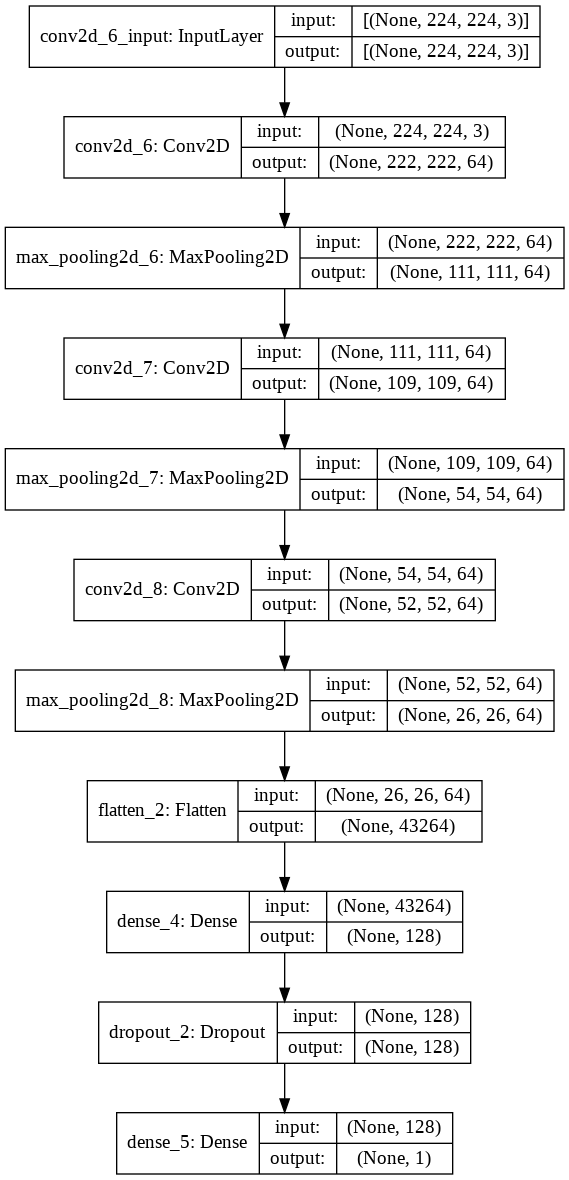

In [ ]:
plot_model(model_best, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

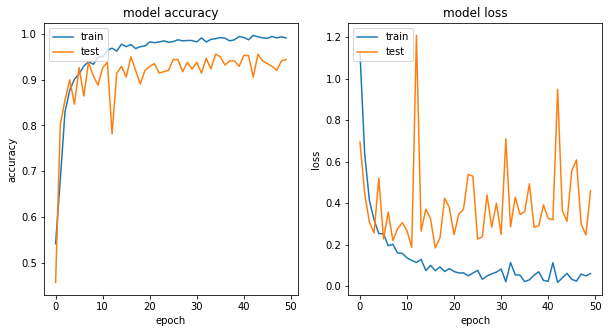

In [ ]:
plot_learning_curve(history)

Se intentará obtener un mejor valor usando un GridSearch que muestre el mejor valor para las épocas y el batch size

In [ ]:
model_keras = KerasClassifier(build_fn=model_cnn_binary_tunn, t_filtro=3, verbose=1)
batch_size = [16, 32, 64]
epochs = [10,30, 50,100]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model_keras, param_grid=param_grid)
grid_result = grid.fit(X_train_cn, y_train_binario)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 41/50
63/63 [==============================] - 2s 35ms/step - loss: 0.0715 - accuracy: 0.9888
Epoch 42/50
63/63 [==============================] - 2s 35ms/step - loss: 0.0556 - accuracy: 0.9920
Epoch 43/50
63/63 [==============================] - 2s 35ms/step - loss: 0.0338 - accuracy: 0.9935
Epoch 44/50
63/63 [==============================] - 2s 35ms/step - loss: 0.0167 - accuracy: 0.9935
Epoch 45/50
63/63 [==============================] - 2s 35ms/step - loss: 0.0613 - accuracy: 0.9874
Epoch 46/50
63/63 [==============================] - 2s 35ms/step - loss: 0.0285 - accuracy: 0.9920
Epoch 47/50
63/63 [==============================] - 2s 35ms/step - loss: 0.0217 - accuracy: 0.9941
Epoch 48/50
63/63 [==============================] - 2s 35ms/step - loss: 0.0418 - accuracy: 0.9953
Epoch 49/50
63/63 [==============================] - 2s 35ms/step - loss: 0.0402 - accuracy: 0.9947
Epoch 50/50
16/16 [====================

In [ ]:
model_best2 = model_cnn_binary_tunn(3)

model_best2.fit(X_train_cn, y_train_binario, validation_data=(X_test_cn, y_test_binario), epochs=10, batch_size=64)

scores = model_best2.evaluate(X_test_cn, y_test_binario, verbose=0)
r = ("Error: %.2f%%, Acc: %.2f%% usando filtros de %r " % ((100-scores[1]*100), scores[1]*100, str(3)+" X "+str(3)))+"\n"
print(r)


Epoch 1/10
20/20 [==============================] - 150s 7s/step - loss: 2.1795 - accuracy: 0.5199 - val_loss: 1.0536 - val_accuracy: 0.4543
Epoch 2/10
20/20 [==============================] - 148s 7s/step - loss: 0.6522 - accuracy: 0.6362 - val_loss: 0.4117 - val_accuracy: 0.7817
Epoch 3/10
20/20 [==============================] - 149s 7s/step - loss: 0.4339 - accuracy: 0.8175 - val_loss: 0.3294 - val_accuracy: 0.8732
Epoch 4/10
20/20 [==============================] - 143s 7s/step - loss: 0.3683 - accuracy: 0.8658 - val_loss: 0.3600 - val_accuracy: 0.8643
Epoch 5/10
20/20 [==============================] - 138s 7s/step - loss: 0.3329 - accuracy: 0.8693 - val_loss: 0.3262 - val_accuracy: 0.8673
Epoch 6/10
20/20 [==============================] - 141s 7s/step - loss: 0.3319 - accuracy: 0.8705 - val_loss: 0.3949 - val_accuracy: 0.8142
Epoch 7/10
20/20 [==============================] - 148s 7s/step - loss: 0.2723 - accuracy: 0.8902 - val_loss: 0.2392 - val_accuracy: 0.9056
Epoch 8/10
20